
All tasks completed.
Execution time: 16.57 seconds


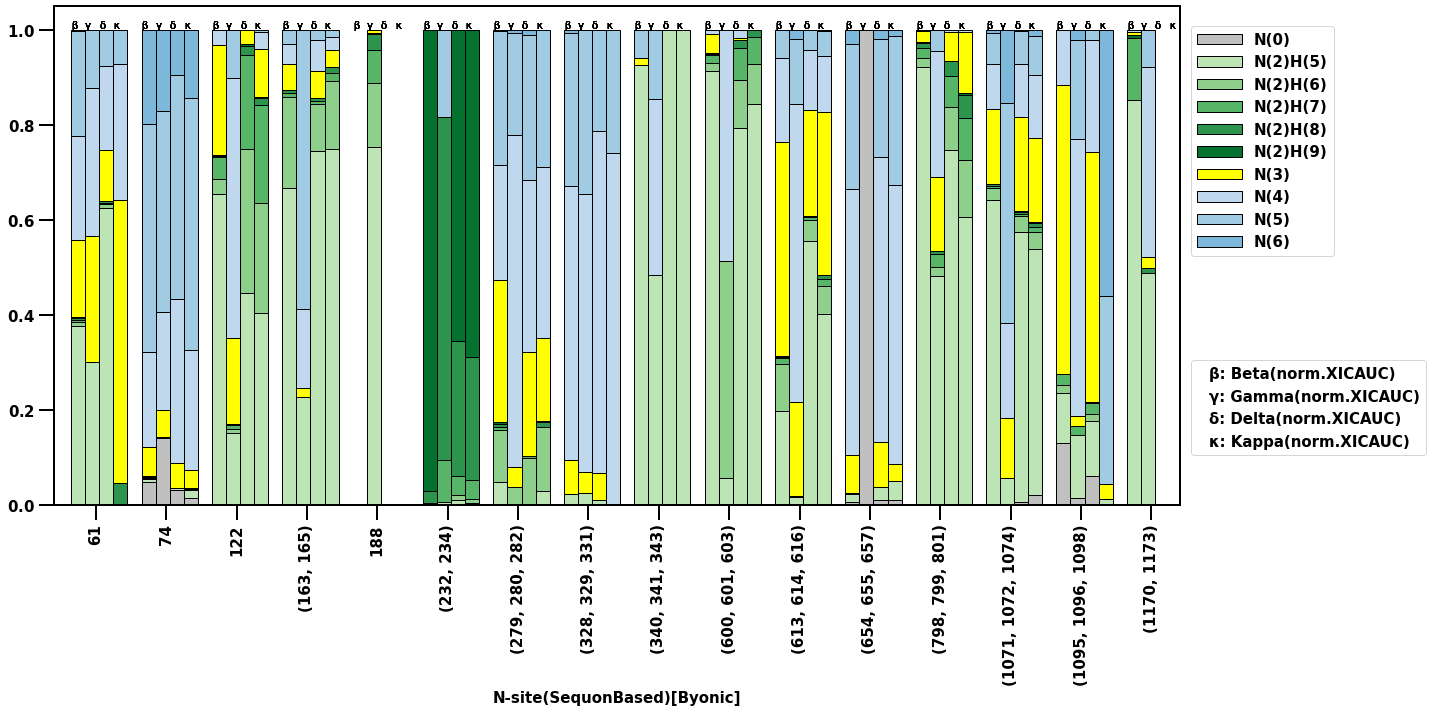

In [1]:
# NOTE!!! THE DATA HERE IS FREE OF GARBAGE(E.G. N(2)H(1)), SO WE DO NOT NEED TO ADD ↑↓ AT THE END OF MAN5 & MAN9 (SO THE STACKED PLOT FUNC HERE IS MODIFIED)
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter
from IPython.display import display, HTML
import re # finding specific patterns in str
import textwrap # split text into equal parts
import collections # return repeated items in list
from collections import OrderedDict
import time
from datetime import datetime # attach current date to export filename
import sys
import ast # convert str back to tuple/list/int, etc
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import string

# FILES TO PROCESS
filnames = ['20210719_UniquePep_S-SA_Insol_TC_NG_Byonic_S-SA_Insol_TC_NG_Byos_S-SA_Insol_TC_NG_pGlyco'\
                , '20210719_UniquePep_S_P1_Insol_TC_NG_Byonic_S-P1_Insol_TC_NG_Byos_S-P1_Insol_TC_NG_pGlyco'\
                , '20210809_UniquePep_SARS-CoV2_S-Delta_Insol_TC_NG_Byonic_SARS-CoV2_S-Delta_Insol_TC_NG_Byos_SARS-CoV2_S-Delta_Insol_TC_NG_pGlyco'\
                , '20210809_UniquePep_SARS-CoV2_S-Kappa_Insol_TC_NG_Byonic_SARS-CoV2_S-Kappa_Insol_TC_NG_Byos_SARS-CoV2_S-Kappa_Insol_TC_NG_pGlyco']

# STRAINS ORDER 
strains = ['Beta', 'Gamma', 'Delta', 'Kappa']

# SELF-DEFINED BAR LABELS (DEFAULT: A, B, C, D)
self_defined_bar_mkr = ['β', 'γ', 'δ', 'κ'] # len should be the same as the num of bars within one x-axis label

# FIX N-SITES TO COMPARE ACROSS DIF MUTANTS (DEAL W/ DELETION, INSERTION...ETC.)
original_nsites = [163, 165, 232, 234, 279, 280, 282, 328, 329, 331, 340, 341, 343, 600, 601, 603, 613, 614, 616, 654, 655, 657, 798, 799, 801, 1071, 1072, 1074, 1095, 1096, 1098, 1170, 1173]
fixed_nsites = ['(163, 165)', '(163, 165)', '(232, 234)', '(232, 234)', '(279, 280, 282)', '(279, 280, 282)', '(279, 280, 282)', '(328, 329, 331)', '(328, 329, 331)', '(328, 329, 331)'\
, '(340, 341, 343)', '(340, 341, 343)', '(340, 341, 343)', '(600, 601, 603)', '(600, 601, 603)', '(600, 601, 603)', '(613, 614, 616)', '(613, 614, 616)', '(613, 614, 616)'\
, '(654, 655, 657)', '(654, 655, 657)', '(654, 655, 657)', '(798, 799, 801)', '(798, 799, 801)', '(798, 799, 801)', '(1071, 1072, 1074)', '(1071, 1072, 1074)', '(1071, 1072, 1074)'\
, '(1095, 1096, 1098)', '(1095, 1096, 1098)', '(1095, 1096, 1098)', '(1170, 1173)', '(1170, 1173)']

# color hybrid yellow or not (default: n3 as hybrid)
colorHybrid = True # only for v3/v4

############################### PLEASE DO NOT ALTER ANYTHING BELOW ###############################
# AUXILIARY FUNCTIONS
def move_df(df, move_col, insert_left_col):
    move_df = df[move_col]
    df.drop(labels=[move_col], axis=1, inplace = True)
    df.insert(df.columns.get_loc(insert_left_col) + 1, move_col, move_df)    

def ReadExcelandFixCols(filename):
    df = pd.read_excel('%s.xlsx'%filename, header = 0)
    df = df.fillna('N/A')
    fixed_colname = [i.replace('_x000D_', '\r') if '_x000D_' in i else i for i in df.columns]
    df.columns = fixed_colname
    return df

# MAIN PROCESSING FUNCS
def GlycanTypeAnalysis(df, glycans_col, sequon_col, software=''): # INSERTS GLYCANTYPEANALYSIS COL TO DF
    N = df[glycans_col].str.findall(r'HexNAc\((\d+)\)')
    N = [[sum(list(map(int, i)))] if type(i) == list else np.nan for i in N]
    df['hexnac'] = N

    H = df[glycans_col].str.findall(r'Hex\((\d+)\)')
    H = [[sum(list(map(int, i)))] if type(i) == list else np.nan for i in H]
    df['hex'] = H

    F = df[glycans_col].str.findall(r'Fuc\((\d+)\)')
    F = [[sum(list(map(int, i)))] if type(i) == list else np.nan for i in F]
    df['fuc'] = F

    NA = df[glycans_col].str.findall(r'NeuAc\((\d+)\)')
    NA = [[sum(list(map(int, i)))] if type(i) == list else np.nan for i in NA]
    df['neuac'] = NA

    NG = df[glycans_col].str.findall(r'NeuGc\((\d+)\)')
    NG = [[sum(list(map(int, i)))] if type(i) == list else np.nan for i in NG]
    df['neugc'] = NG

    df['glycancode'] = df['hexnac'] + df['hex'] + df['fuc'] + df['neuac'] + df['neugc']
    df.loc[(df[glycans_col] == 'N/A'), 'glycancode'] = 'N/A'
    df.loc[(df[glycans_col] == -1), 'glycancode'] = -1

    # extract numbers in each glyco composition gp
    df['hexnac'] = [i[0] if type(i) == list else i for i in df['hexnac']]
    df['hex'] = [i[0] if type(i) == list else i for i in df['hex']]
    df['hex-hexnac'] = df['hex']-df['hexnac']
    df['fuc'] = [i[0] if type(i) == list else i for i in df['fuc']]
    df['neuac'] = [i[0] if type(i) == list else i for i in df['neuac']]
    df['neugc'] = [i[0] if type(i) == list else i for i in df['neugc']]

    # HIGHMAN (24000~29000)
    df.loc[(df['hexnac']==2)&(df['hex']<=9)&(df['hex']>=4), 'GlycanTypeAnalysis'] = 'Man'
    df['GlycanTypeAnalysis'] = df['GlycanTypeAnalysis'] + df['hex'].astype('Int64').astype(str)
    # ONLY CORE
    df.loc[(df['hexnac']==2)&(df['hex']==3), 'GlycanTypeAnalysis'] = 'Only core!'
    # THE CORE IS NOT COMPLETE
    df.loc[(df['hexnac']<2)|(df['hex']<3), 'GlycanTypeAnalysis'] = 'The core is not complete!' # any one of them is below 23000 composition could happen
    # PRECURSOR (>29000)
    df.loc[(df['hexnac']==2)&(df['hex']>9), 'GlycanTypeAnalysis'] = 'Potential N-glycan precursor'
    # MULTI-SITES
    # cannot form any core
    df.loc[(df[sequon_col].apply(lambda x: isinstance(x, tuple)))&((df['hexnac']<=2)|(df['hex']<3)), 'GlycanTypeAnalysis'] = 'Multi Site: Cannot form any core!' 
    # only 1 core
    df.loc[(df[sequon_col].apply(lambda x: isinstance(x, tuple)))&((df['hexnac']==2)&(df['hex']==3)), 'GlycanTypeAnalysis'] = 'Multi Site: Only 1 core!' 
    # count psm once: highman
    df.loc[(df[sequon_col].apply(lambda x: isinstance(x, tuple)))&((df['hexnac']==2)&(df['hex']>3)), 'GlycanTypeAnalysis'] = 'Multi Site [count PSM once]: Highmannose'
    # count psm once: hybrid/complex
    df.loc[(df[sequon_col].apply(lambda x: isinstance(x, tuple)))&((df['hexnac']>2)&(df['hex']>=3)), 'GlycanTypeAnalysis'] = 'Multi Site [count PSM once]: Hybrid/Complex'
    # 2 cores
    df.loc[(df[sequon_col].apply(lambda x: isinstance(x, tuple)))&((df['hexnac']==4)&(df['hex']==6)), 'GlycanTypeAnalysis'] = 'Multi Site: 2 cores!'
    # count psm twice: highman
    df.loc[(df[sequon_col].apply(lambda x: isinstance(x, tuple)))&((df['hexnac']==4)&(df['hex']>6)), 'GlycanTypeAnalysis'] = 'Multi Site [count PSM twice]: Highmannose'
    # count psm twice: hybrid/complex
    df.loc[(df[sequon_col].apply(lambda x: isinstance(x, tuple)))&((df['hexnac']>4)&(df['hex']>=6)), 'GlycanTypeAnalysis'] = 'Multi Site [count PSM twice]: Hybrid/Complex'
    # SINGLE COMPLEX & HYBRID (REMEMBER TO CONSIDER FUCOSE)
    # single complex no f
    df.loc[(df[sequon_col].apply(lambda x: isinstance(x, str)))&((df['hexnac']==3)&(df['hex-hexnac']<2)&(df['fuc']==0)), 'GlycanTypeAnalysis'] = 'A1' 
    df.loc[(df[sequon_col].apply(lambda x: isinstance(x, str)))&((df['hexnac']==4)&(df['hex-hexnac']<2)&(df['fuc']==0)), 'GlycanTypeAnalysis'] = 'A2/A1B' 
    df.loc[(df[sequon_col].apply(lambda x: isinstance(x, str)))&((df['hexnac']==5)&(df['hex-hexnac']<2)&(df['fuc']==0)), 'GlycanTypeAnalysis'] = 'A3/A2B' 
    df.loc[(df[sequon_col].apply(lambda x: isinstance(x, str)))&((df['hexnac']>=6)&(df['hex-hexnac']<2)&(df['fuc']==0)), 'GlycanTypeAnalysis'] = 'A4/A3B' 
    # single complex w/ f 
    df.loc[(df[sequon_col].apply(lambda x: isinstance(x, str)))&((df['hexnac']==3)&(df['hex-hexnac']<2)&(df['fuc']!=0)), 'GlycanTypeAnalysis'] = 'FA1' 
    df.loc[(df[sequon_col].apply(lambda x: isinstance(x, str)))&((df['hexnac']==4)&(df['hex-hexnac']<2)&(df['fuc']!=0)), 'GlycanTypeAnalysis'] = 'FA2/FA1B' 
    df.loc[(df[sequon_col].apply(lambda x: isinstance(x, str)))&((df['hexnac']==5)&(df['hex-hexnac']<2)&(df['fuc']!=0)), 'GlycanTypeAnalysis'] = 'FA3/FA2B' 
    df.loc[(df[sequon_col].apply(lambda x: isinstance(x, str)))&((df['hexnac']>=6)&(df['hex-hexnac']<2)&(df['fuc']!=0)), 'GlycanTypeAnalysis'] = 'FA4/FA3B' 
    # single hybrid no f
    df.loc[(df[sequon_col].apply(lambda x: isinstance(x, str)))&((df['hexnac']>=3)&(df['hex-hexnac']>=2)&(df['fuc']==0)), 'GlycanTypeAnalysis'] = 'Hybrid' 
    # single hybrid w/ f
    df.loc[(df[sequon_col].apply(lambda x: isinstance(x, str)))&((df['hexnac']>=3)&(df['hex-hexnac']>=2)&(df['fuc']!=0)), 'GlycanTypeAnalysis'] = 'Fhybrid' 
    # UNOCCUPIED
    df.loc[(df[glycans_col]=='N/A'), 'GlycanTypeAnalysis'] = 'Unoccupied'
    # MISSING DATA
    df.loc[(df[glycans_col]==-1), 'GlycanTypeAnalysis'] = -1
    # DROP REDUNDANT COLS
    df = df.drop(['glycancode', 'hexnac', 'hex', 'fuc', 'neuac', 'neugc', 'hex-hexnac'], axis = 1)
    # RENAME COL FOR DIF SOFTWARE
    df = df.rename(columns={'GlycanTypeAnalysis':'GlycanTypeAnalysis%s'%(software)}) 
    # MOVE RESULT
    move_df(df, 'GlycanTypeAnalysis%s'%(software), glycans_col)
    return df

# generate onlyb file originally use for quant
def toQuantProcessing(id_df): 
    # only single sites for quant (quant_df offers important info. for later multiIndex df construction)
    quant = id_df[id_df['N-site(SequonBased)[Byonic]'].apply(lambda x: isinstance(x, int))]
    # for this version we need to delete certain glycantype & normalize again to keep the total as 1(100%)
    quant = quant.loc[(quant['GlycanTypeAnalysis[Byonic]']!='Only core!')&(quant['GlycanTypeAnalysis[Byonic]']!='The core is not complete!')&(quant['GlycanTypeAnalysis[Byonic]']!='Potential N-glycan precursor')&(quant['GlycanTypeAnalysis[Byonic]']!='Man4')]
    # avoid adding values from below-threshold rows: if deepgreen -> change value to -1, if deepblue -> change value to -1.(-1 to make lambda function easier to write)
    quant.loc[(quant['ColorCode']=='deepgreen(#66ff66)'), ['MonoArea[pGlyco]', 'IsotopeArea[pGlyco]']] = -1
    quant.loc[(quant['ColorCode']=='deepblue(#66b3ff)'), ['XIC\r\nAUC[Byos]', 'Apex Int.\r\n(Posit)[Byos]']] = -1
    # calculate the sum within each n-site, then normalize xicauc/ int/ mono/ iso by these sum
    quant['sumpersite_xicauc'] = quant.groupby(['N-site(SequonBased)[Byonic]'])['XIC\r\nAUC[Byos]'].transform(lambda x: x[x!=-1].sum())
    quant['sumpersite_int'] = quant.groupby(['N-site(SequonBased)[Byonic]'])['Apex Int.\r\n(Posit)[Byos]'].transform(lambda x: x[x!=-1].sum())
    quant['sumpersite_mono'] = quant.groupby(['ProSites[pGlyco]'])['MonoArea[pGlyco]'].transform(lambda x: x[x!=-1].sum())
    quant['sumpersite_iso'] = quant.groupby(['ProSites[pGlyco]'])['IsotopeArea[pGlyco]'].transform(lambda x: x[x!=-1].sum())
    # using groupby transform sum function to add 8 cols (byos xicauc/byos area int/pglycomono/pglycoisotope) recording summed values & normalized values (same site & same glycan & seq can be dif)
    quant['e_sum_XIC\r\nAUC[Byos]'] = quant.groupby(['N-site(SequonBased)[Byonic]', 'Glycans[Byonic]'])['XIC\r\nAUC[Byos]'].transform(lambda x: x[x != -1].sum())
    quant['f_sum_Apex Int.\r\n(Posit)[Byos]'] = quant.groupby(['N-site(SequonBased)[Byonic]', 'Glycans[Byonic]'])['Apex Int.\r\n(Posit)[Byos]'].transform(lambda x: x[x != -1].sum())
    quant['g_sum_MonoArea[pGlyco]'] = quant.groupby(['ProSites[pGlyco]', 'GlycanComposition_ByonicStyle[pGlyco]'])['MonoArea[pGlyco]'].transform(lambda x: x[x != -1].sum())
    quant['h_sum_IsotopeArea[pGlyco]'] = quant.groupby(['ProSites[pGlyco]', 'GlycanComposition_ByonicStyle[pGlyco]'])['IsotopeArea[pGlyco]'].transform(lambda x: x[x != -1].sum())
    quant['a_norm_XIC\r\nAUC[Byos]'] = quant['e_sum_XIC\r\nAUC[Byos]']/quant['sumpersite_xicauc']
    quant['b_norm_Apex Int.\r\n(Posit)[Byos]'] = quant['f_sum_Apex Int.\r\n(Posit)[Byos]']/quant['sumpersite_int']
    quant['c_norm_MonoArea[pGlyco]'] = quant['g_sum_MonoArea[pGlyco]']/quant['sumpersite_mono']
    quant['d_norm_IsotopeArea[pGlyco]'] = quant['h_sum_IsotopeArea[pGlyco]']/quant['sumpersite_iso']
    # since it's possible to have real 0 from calculation, change the real absent data back to -1 in sum_ & norm_
    quant.loc[quant['MonoArea[pGlyco]'] == -1, ['g_sum_MonoArea[pGlyco]', 'h_sum_IsotopeArea[pGlyco]', 'c_norm_MonoArea[pGlyco]', 'd_norm_IsotopeArea[pGlyco]']] = -1
    quant.loc[quant['XIC\r\nAUC[Byos]'] == -1, ['e_sum_XIC\r\nAUC[Byos]', 'f_sum_Apex Int.\r\n(Posit)[Byos]', 'a_norm_XIC\r\nAUC[Byos]', 'b_norm_Apex Int.\r\n(Posit)[Byos]']] = -1 
    # extract the needed cols only & split byonicbyos/pglyco, drop all -1 rows, glycans as index to outer union concat data again
    quant_bb = quant[['N-site(SequonBased)[Byonic]', 'Glycans[Byonic]', 'GlycanTypeAnalysis[Byonic]', 'e_sum_XIC\r\nAUC[Byos]', 'f_sum_Apex Int.\r\n(Posit)[Byos]', 'a_norm_XIC\r\nAUC[Byos]', 'b_norm_Apex Int.\r\n(Posit)[Byos]']]
    quant_bb = quant_bb.loc[quant_bb['N-site(SequonBased)[Byonic]'] != -1].drop_duplicates()
    # change all -1 to 0 for plotting (NaN will raise error in later plotting)
    quant_bb.replace(to_replace = -1, value = 0 , inplace = True)
    return quant_bb

# modify yu-chun's version of stacked plots to show M5-M9 whithin N2 with green colormap (N2H5-N2H9)
def nxhy(df): # like a more detailed version of yu-chun's nx func (mainly process quant_bb)
    n = [int(lst[0]) if lst!=[] else 0 for lst in df['Glycans[Byonic]'].str.findall(r'HexNAc\((\d+)\)').tolist()]
    h = [int(lst[0]) if lst!=[] else 0 for lst in df['Glycans[Byonic]'].str.findall(r'Hex\((\d+)\)').tolist()]
    nxhy = [(n[i], h[i]) for i in range(len(n))]
    nxhy_fix = ['N(%s)'%(t[0]) if t[0]!=2 else 'N(%s)H(%s)'%(t[0], t[1]) for t in nxhy]
    # type_col = ['(a)Unoccupied&Others' if t[0]<=1 else '(b)OligoMannose' if t[0]==2 else '(c)Hybrid' if t[0]==3 else '(d)Complex' for t in nxhy]
    df.insert(0 , 'N(x)H(y)', nxhy_fix , True)
    # df.insert(0 , 'Type', type_col , True)
    nxhy_fix_order = sorted(list(set(nxhy_fix)))
    nxhy_fix_order = sorted(nxhy_fix_order, key=lambda x: int(re.findall(r'[0-9]+', x)[0]))
    return df, nxhy_fix_order

# # modified plotting func from yu-chun version to separate highmans with greens colormap
# def detailedHighman_plot_clustered_stacked(dfall, nsum, labels=None, title='', selfDefinedBarMkr=None, neugc_exist=None, tickW=2, tickL=15, spineW=2, xlabelsize=15, ticklabelsize=15, xlabel_rotation=90, xlabelpad=5, legend_fontsize=15, legend_handleL=3, hatch_lineW=1, bar_labelpad=0, bar_labelfontsize=7):
#     # Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot
#     # labels is a list of the names of the dataframe, used for the legend
#     # title is a string for the title of the plot
#     # H is the hatch used for identification of the different dataframe
#     n_df = len(dfall)
#     n_col = len(dfall[0].columns) 
#     n_ind = len(dfall[0].index)
#     k = dfall[0].columns.tolist()
    
#     # sample the colormaps
#     if neugc_exist is None: # this section caters to v1 plotting
#         # extract the largest n number in col to determine the color dict range
#         # so that the color-nnumber relation is locked
#         # n_max = ast.literal_eval(re.findall(r'N\((\d+)\)', k[-1])[0])
#         n_max = 12 # default to 12 to make sure the gradients are the same across dif plots
#         b = plt.cm.Blues(np.linspace(0, 1, (n_max)))[2:] # can be more than N(10)
#         gw = plt.cm.gray(np.linspace(0, 1, 5))[-2:]
#         highman_g = plt.cm.Greens(np.linspace(0, 1, 8))[2:7] # man5-man9
    
#     # combine them and build a new colormap
#     # modified v1 (separated highman)
#     colors = np.vstack((gw, highman_g, b)) # b is unlimited cmap determined by n_max
#     # construct 1 to 1 color dict
#     n = ['N(%s)'%i for i in range(n_max+1) if i!=2]
#     highman = ['N(2)H(%s)'%(i) for i in range(5, 10, 1)]
#     n[2:2] = highman
#     c = [colors[i] for i in range(len(n))]
#     nc_dict = dict(zip(n, c)) # given k lst, can get v = c. v = nc_dict[k[k_cnt]]
        
#     # make tick & spine thick.
#     fig, axe = plt.subplots()
#     axes = plt.gca()
#     axes.xaxis.set_tick_params(width=tickW, length=tickL)
#     axes.yaxis.set_tick_params(width=tickW, length=tickL)
#     for axis in ['top','bottom','left','right']:
#         axes.spines[axis].set_linewidth(spineW)
        
#     # start plotting
#     if selfDefinedBarMkr is None:
#         bar_label = [string.ascii_uppercase[i] for i in range(n_df)]
#     else:
#         bar_label = selfDefinedBarMkr
#     bar_label_cnt = 0
#     for df in dfall : # for each data frame
#         if 'norm' in labels[0]: # add edge to the bar
#             axe = df.plot(kind='bar', stacked=True, ax=axe, legend=False, grid=False, figsize =(20, 10), edgecolor = 'k')  # make bar plots
#         else: # sum: no edge for clarity
#             axe = df.plot(kind='bar', stacked=True, ax=axe, legend=False, grid=False, figsize =(20, 10))  # make bar plots
#     # get the y aixs range
#     ymin, ymax = axes.get_ylim()
#     # get the handles we want to modify in each site, h: 44 barcontainers, l: 4 full N(x) cols
#     h,l = axe.get_legend_handles_labels() 
#     # print('h:%s\n'%h) 44 <BarContainer object of 29 artists> 
#     for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df -> 0, 11, 22, 33
#         k_cnt = 0 # iterate thru k for rect color fix
#         for j, pa in enumerate(h[i:i+n_col]): # each pa.patches contains 29 <matplotlib.patches.Rectangle object>
#             # print('pa.patches:%s\n'%pa.patches)
#             rect_cnt = 0
#             for rect in pa.patches: # each rect here is one single N(X) small rect of one single xicauc(int...etc) big rect. Note this loops thru the small rects spanning dif n-sites (iterate thru 29 small rects)
#                 rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))    
#                 rect.set_width(1 / float(n_df + 1))
#                 axe.text(rect.get_x(), nsum[bar_label_cnt][rect_cnt] + bar_labelpad, bar_label[bar_label_cnt], ha='left', va='bottom')
#                 rect.set_facecolor(nc_dict[k[k_cnt]]) # use this to fix rect color & legend
#                 rect_cnt += 1
#             k_cnt += 1
#         bar_label_cnt += 1
    
#     axe.tick_params(axis='both', labelsize=ticklabelsize)
#     axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
#     axe.set_xticklabels(df.index, rotation = xlabel_rotation, fontweight="bold") 
#     axe.set_xlabel(df.index.name, fontweight="bold", fontsize = xlabelsize, labelpad = xlabelpad)
#     axe.ticklabel_format(axis='y')
#     axe.yaxis.offsetText.set_fontsize(30)
#     axe.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#     for label in axe.get_yticklabels():
#         label.set_fontweight('bold')
#     axe.set_title(title)
    
#     # legend properties
#     params = {'legend.fontsize': legend_fontsize, 'legend.handlelength': legend_handleL, 'hatch.linewidth': hatch_lineW}
#     legend_properties = {'weight':'bold'}
#     plt.rcParams.update(params)
    
#     # Add invisible data to add another legend 
#     l1 = axe.legend(h[:n_col], l[:n_col], prop=legend_properties, loc=[1.01, 0.5])
    
#     legend_elements = [] # for df legend (xicauc, int.. are from dif. df) 
#     if labels is not None:      
#         for i in range(n_df):
#             label = '%s: %s'%(bar_label[i], labels[i])
#             each_bullet = Patch(label = label)
#             legend_elements.append(each_bullet)
#         plt.legend(handles=legend_elements, handlelength = 0, prop=legend_properties, loc=[1.01, 0.1]) # set handleL=0 to hide Patch
#     axe.add_artist(l1)
    
#     return fig

# PLOTTING FUNC
def plot_clustered_stacked(dfall, nsum, labels=None, title='', selfDefinedBarMkr=None, neugc_exist=None, detailedHighMan=False, fucosylation=False, hybrid=colorHybrid, tickW=2, tickL=15, spineW=2, xlabelsize=15, ticklabelsize=15, xlabel_rotation=90, xlabelpad=5, legend_fontsize=15, legend_handleL=3, hatch_lineW=1, bar_labelpad=0, bar_labelfontsize=7):
    # NOTE THE DEFAULT STYLE OF THIS FUNC IS V1/V2 (V1: original Yu-Chun version, V2: original Yu-Chun version, V3: detailedHighMan=True,fucosylation=False, hybrid=TorF(color or not) / V4: detailedHighMan=True,fucosylation=True, hybrid=TorF(color or not))
    # Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot
    # labels is a list of the names of the dataframe, used for the legend
    # title is a string for the title of the plot
    # H is the hatch used for identification of the different dataframe
    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    k = dfall[0].columns.tolist()
    
    # colormaps
    gw = plt.cm.gray(np.linspace(0, 1, 5))[-2:]
    single_p = plt.cm.Purples(np.linspace(0, 1, 10))[5]
    single_b = plt.cm.Blues(np.linspace(0, 1, 10))[5]
    single_r = plt.cm.Reds(np.linspace(0, 1, 5))[3]
    single_g = plt.cm.Greens(np.linspace(0, 1, 4))[2]

    if neugc_exist is None: # this section caters to v1/v3/v4 plotting
        # extract the largest n number in col to determine the color dict range
        # so that the color-nnumber relation is locked
        # n_max = ast.literal_eval(re.findall(r'N\((\d+)\)', k[-1])[0])
        n_max = 12 # default to 12 to make sure the gradients are the same across dif plots
        b = plt.cm.Blues(np.linspace(0, 1, n_max))[2:] # can be more than N(10) # for v1 & v3
        if fucosylation == True: # Reds for fucosylation 
            fuc = plt.cm.Reds(np.linspace(0, 1, n_max+2))[2:] # just like complex having unlimited range
        else:
            pass

        if detailedHighMan == True:
            highman_g = plt.cm.Greens(np.linspace(0, 1, 8))[2:7] # man5&below-man9&above
        else:
            pass

        if hybrid == True: 
            hybrid_y = plt.cm.spring(np.linspace(0, 1, 6))[-1] # only n3(orange). fn3 will be colored red also for clarity
            hybrid_b = plt.cm.Blues(np.linspace(0, 1, n_max))[3:] # n3 will be colored orange, so blue starts from n4
        else:
            pass 

    # combine them and build a new colormap
    if neugc_exist == True: # v2, complex+sia in red
        colors = np.vstack((gw, single_g, single_b, single_r)) 
        # construct 1 to 1 color dict
        n = ['N(0)', 'N(1)', 'OligoMannose', 'Complex', 'Complex+Sia'] # limited categories
        c = [colors[i] for i in range(len(n))]
        nc_dict = dict(zip(n, c)) # given k lst, can get v = c. v = nc_dict[k[k_cnt]]
    elif neugc_exist == False: # v2, complex+sia in purple
        colors = np.vstack((gw, single_g, single_b, single_p)) 
        # construct 1 to 1 color dict
        n = ['N(0)', 'N(1)', 'OligoMannose', 'Complex', 'Complex+Sia'] # limited categories
        c = [colors[i] for i in range(len(n))]
        nc_dict = dict(zip(n, c)) # given k lst, can get v = c. v = nc_dict[k[k_cnt]]
    else: # v1/v3/v4
        if detailedHighMan == False and fucosylation == False: # v1
            colors = np.vstack((gw, single_g, b)) # b is unlimited cmap determined by n_max
            # construct 1 to 1 color dict
            n = ['N(%s)'%i for i in range(n_max+1)] # e.g. N(0)-N(10), can be more than 11 cols # unlimited categories
            c = [colors[i] for i in range(len(n))]
            nc_dict = dict(zip(n, c)) # given k lst, can get v = c. v = nc_dict[k[k_cnt]]
        elif detailedHighMan == True and fucosylation == False: # v3
            if hybrid == True:
                colors = np.vstack((gw, highman_g, hybrid_y, hybrid_b)) # b is unlimited cmap determined by n_max
                # construct 1 to 1 color dict
                n = ['N(%s)'%i for i in range(n_max+1) if i!=2]
                highman = ['N(2)H(%s)'%(i) if i==5 else 'N(2)H(%s)'%(i) if i==9 else 'N(2)H(%s)'%(i) for i in range(5, 10, 1)]
                n[2:2] = highman
                c = [colors[i] for i in range(len(n))]
                nc_dict = dict(zip(n, c)) # given k lst, can get v = c. v = nc_dict[k[k_cnt]]
            else:
                colors = np.vstack((gw, highman_g, b)) # b is unlimited cmap determined by n_max
                # construct 1 to 1 color dict
                n = ['N(%s)'%i for i in range(n_max+1) if i!=2]
                highman = ['N(2)H(%s)'%(i) if i==5 else 'N(2)H(%s)'%(i) if i==9 else 'N(2)H(%s)'%(i) for i in range(5, 10, 1)]
                n[2:2] = highman
                c = [colors[i] for i in range(len(n))]
                nc_dict = dict(zip(n, c)) # given k lst, can get v = c. v = nc_dict[k[k_cnt]]
        elif detailedHighMan == True and fucosylation == True: # v4
            if hybrid == True:
                colors = np.vstack((gw, highman_g, hybrid_y, hybrid_b, fuc)) # b & cyans are unlimited cmap determined by n_max
                # construct 1 to 1 color dict
                n = [' N(%s)'%i for i in range(n_max+1) if i!=2]
                highman = [' N(2)H(%s)'%(i) if i==5 else ' N(2)H(%s)'%(i) if i==9 else ' N(2)H(%s)'%(i) for i in range(5, 10, 1)]
                n[2:2] = highman
                # append fucosylation for cyans colormap
                f = ['FN(%s)'%i for i in range(1, n_max+1)]
                n.extend(f)
                c = [colors[i] for i in range(len(n))]
                nc_dict = dict(zip(n, c)) # given k lst, can get v = c. v = nc_dict[k[k_cnt]]
            else:
                colors = np.vstack((gw, highman_g, b, fuc)) # b & cyans are unlimited cmap determined by n_max
                # construct 1 to 1 color dict
                n = [' N(%s)'%i for i in range(n_max+1) if i!=2]
                highman = [' N(2)H(%s)'%(i) if i==5 else ' N(2)H(%s)'%(i) if i==9 else ' N(2)H(%s)'%(i) for i in range(5, 10, 1)]
                n[2:2] = highman
                # append fucosylation for cyans colormap
                f = ['FN(%s)'%i for i in range(1, n_max+1)]
                n.extend(f)
                c = [colors[i] for i in range(len(n))]
                nc_dict = dict(zip(n, c)) # given k lst, can get v = c. v = nc_dict[k[k_cnt]]

    # make tick & spine thick.
    fig, axe = plt.subplots()
    axes = plt.gca()
    axes.xaxis.set_tick_params(width=tickW, length=tickL)
    axes.yaxis.set_tick_params(width=tickW, length=tickL)
    for axis in ['top','bottom','left','right']:
        axes.spines[axis].set_linewidth(spineW)
        
    # start plotting
    if selfDefinedBarMkr is None:
        bar_label = [string.ascii_uppercase[i] for i in range(n_df)]
    else:
        bar_label = selfDefinedBarMkr
    bar_label_cnt = 0
    for df in dfall : # for each data frame
        if 'norm' in labels[0]: # add edge to the bar
            axe = df.plot(kind='bar', stacked=True, ax=axe, legend=False, grid=False, figsize =(20, 10), edgecolor = 'k')  # make bar plots
        else: # sum: no edge for clarity
            axe = df.plot(kind='bar', stacked=True, ax=axe, legend=False, grid=False, figsize =(20, 10))  # make bar plots
    # get the y aixs range
    ymin, ymax = axes.get_ylim()
    # get the handles we want to modify in each site, h: 44 barcontainers, l: 4 full N(x) cols
    h,l = axe.get_legend_handles_labels() 
    # print('h:%s\n'%h) 44 <BarContainer object of 29 artists> 
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df -> 0, 11, 22, 33
        k_cnt = 0 # iterate thru k for rect color fix
        for j, pa in enumerate(h[i:i+n_col]): # each pa.patches contains 29 <matplotlib.patches.Rectangle object>
            # print('pa.patches:%s\n'%pa.patches)
            rect_cnt = 0
            for rect in pa.patches: # each rect here is one single N(X) small rect of one single xicauc(int...etc) big rect. Note this loops thru the small rects spanning dif n-sites (iterate thru 29 small rects)
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))    
                rect.set_width(1 / float(n_df + 1))
                axe.text(rect.get_x(), nsum[bar_label_cnt][rect_cnt] + bar_labelpad, bar_label[bar_label_cnt], ha='left', va='bottom')
                rect.set_facecolor(nc_dict[k[k_cnt]]) # use this to fix rect color & legend
                rect_cnt += 1
            k_cnt += 1
        bar_label_cnt += 1
    
    axe.tick_params(axis='both', labelsize=ticklabelsize)
    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = xlabel_rotation, fontweight="bold") 
    axe.set_xlabel(df.index.name, fontweight="bold", fontsize = xlabelsize, labelpad = xlabelpad)
    axe.ticklabel_format(axis='y')
    axe.yaxis.offsetText.set_fontsize(30)
    axe.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    for label in axe.get_yticklabels():
        label.set_fontweight('bold')
    axe.set_title(title)
    
    # legend properties
    params = {'legend.fontsize': legend_fontsize, 'legend.handlelength': legend_handleL, 'hatch.linewidth': hatch_lineW}
    legend_properties = {'weight':'bold'}
    plt.rcParams.update(params)
    
    # Add invisible data to add another legend 
    l1 = axe.legend(h[:n_col], l[:n_col], prop=legend_properties, loc=[1.01, 0.5])
    
    legend_elements = [] # for df legend (xicauc, int.. are from dif. df) 
    if labels is not None:      
        for i in range(n_df):
            label = '%s: %s'%(bar_label[i], labels[i])
            each_bullet = Patch(label = label)
            legend_elements.append(each_bullet)
        plt.legend(handles=legend_elements, handlelength = 0, prop=legend_properties, loc=[1.01, 0.1]) # set handleL=0 to hide Patch
    axe.add_artist(l1)
    
    return fig

# RECORD DATE TODAY
date = datetime.now().strftime('%Y%m%d')
# TIMESTAMP
start_time = time.time()
# START BATCH PROCESSING
dfs_to_concat, col_order_lst, bNORM_dfall_lstv1, bNORM_label_lstv1 = [],[],[],[]
strain_cnt = 0
if original_nsites != [] and fixed_nsites != []:
    ori_to_fixed_dict = dict(zip(original_nsites, fixed_nsites))
else:
    pass

for filename in filnames:
    # READ IN DF & FIX COLS 
    df = ReadExcelandFixCols(filename)
    # COLUMN NAMES IN DIF INPUT FILE COMBO (2 situations: single/double processing)
    if 'Glycans' in df.columns.tolist(): # only b
        glycans_col = 'Glycans'
        sequon_col = 'Sequon'
        site_col = 'N-site(SequonBased)'
    elif 'GlycanComposition_ByonicStyle' in df.columns.tolist(): # only p
        glycans_col = 'GlycanComposition_ByonicStyle'
        sequon_col = 'Sequon'
        site_col = 'ProSites'
    elif 'Glycans[Byonic]' in df.columns.tolist() and 'GlycanComposition_ByonicStyle[pGlyco]' not in df.columns.tolist(): # byonic + byos
        glycans_col = 'Glycans[Byonic]'
        sequon_col = 'Sequon[Byonic]'
        site_col = 'N-site(SequonBased)[Byonic]'
    else: # bp all present
        b_glycans_col = 'Glycans[Byonic]'
        p_glycans_col = 'GlycanComposition_ByonicStyle[pGlyco]'
        b_sequon_col = 'Sequon[Byonic]'
        p_sequon_col = 'Sequon[pGlyco]'
        b_site_col = 'N-site(SequonBased)[Byonic]'
        p_site_col = 'ProSites[pGlyco]'
    # FIX SEQUON DATATYPE
    if 'Glycans[Byonic]' in df.columns.tolist() and 'GlycanComposition_ByonicStyle[pGlyco]' in df.columns.tolist(): # bp all present
        b_sequon = df[b_sequon_col].tolist()
        p_sequon = df[p_sequon_col].tolist()
        # make sure that sequon are presented as correct data types
        b_sequon = [int(i) if i == '-1' else ast.literal_eval(i) if type(i) == str and '(' in i else i for i in b_sequon]
    #     b_multi_sites_ind = [ i for i in range(len(b_sequon)) if type(b_sequon[i]) == tuple] # sequon-based multi-sites. Computer may assign single glycan
        p_sequon = [int(i) if i == '-1' else ast.literal_eval(i) if type(i) == str and '(' in i else i for i in p_sequon]
    #     p_multi_sites_ind = [ i for i in range(len(p_sequon)) if type(p_sequon[i]) == tuple] # sequon-based multi-sites. Computer may assign single glycan
        df[b_sequon_col] = b_sequon
        df[p_sequon_col] = p_sequon
    else: # only b or only p or byonic + byos
        sequon = df[sequon_col].tolist()
        # make sure that sequon are presented as correct data types
        sequon = [int(i) if i == '-1' else ast.literal_eval(i) if type(i) == str and '(' in i else i for i in sequon]
    #     multi_sites_ind = [ i for i in range(len(sequon)) if type(sequon[i]) == tuple] # sequon-based multi-sites. Computer may assign single glycan
        df[sequon_col] = sequon

    if 'Glycans[Byonic]' in df.columns.tolist() and 'GlycanComposition_ByonicStyle[pGlyco]' in df.columns.tolist(): # bp all present
        df = GlycanTypeAnalysis(df, b_glycans_col, b_sequon_col, '[Byonic]')
        df = GlycanTypeAnalysis(df, p_glycans_col, p_sequon_col, '[pGlyco]')
        if 'XIC\r\nAUC[Byos]' in df.columns.tolist():
            quant_b = toQuantProcessing(df)
            # prepare modified Khoo's version (XICAUC)
            strain = strains[strain_cnt]
            # onlyb norm v1 modified version (w/ detailed highman)
            b_xicaucNORM_df = quant_b.loc[:, ['Glycans[Byonic]', 'N-site(SequonBased)[Byonic]', 'a_norm_XIC\r\nAUC[Byos]']]
            b_xicaucNORM_df = b_xicaucNORM_df.rename(columns={'a_norm_XIC\r\nAUC[Byos]':f'{strains[strain_cnt]}(norm.XICAUC)'})
            b_xicaucNORM_df.replace(to_replace = -1, value = np.nan , inplace = True)
            dfs_to_concat.append(b_xicaucNORM_df)
            strain_cnt += 1

    elif 'Glycans[Byonic]' in df.columns.tolist() and 'GlycanComposition_ByonicStyle[pGlyco]' not in df.columns.tolist(): # byonic + byos
            pass
        # df = GlycanTypeAnalysis(df, glycans_col, sequon_col, '[Byonic]') # if not single software, the source label will still be there 
        # quant_b = toQuantProcessing(df)

    else: # only b or only p -> no byos, no need to plot quant for this version
            pass
        # df = GlycanTypeAnalysis(df, glycans_col, sequon_col)

# CONCAT DFS VERTICALLY FOR XICAUC SUMMARY PLOTS OF BETA/GAMMA/DELTA/KAPPA
all_df = pd.concat(dfs_to_concat, join = 'outer').drop_duplicates().reset_index(drop = True) # concat vertically w/ union of cols & rows
# REPLACE N-SITES TO COMPARE BTW DIF STRAINS (USING DICT)
if original_nsites != [] and fixed_nsites != []:
    all_df = all_df.replace({'N-site(SequonBased)[Byonic]' : ori_to_fixed_dict})
else:
    pass
# RECORD N-SITES ORDER (DEAL W/ FIXED SITES IN STR DATA-TYPE)

# sort by N-site(SequonBased)[Byonic]
all_df['N-site(SequonBased)[Byonic]'] = [ast.literal_eval(i) if type(i)==str else i for i in all_df['N-site(SequonBased)[Byonic]']]
new_nsite_order = all_df['N-site(SequonBased)[Byonic]'].tolist()
new_nsite_order = sorted(list(set(new_nsite_order)), key=lambda v: (isinstance(v, tuple), v))
new_nsite_order = sorted(new_nsite_order, key=lambda x: x[0] if type(x)==tuple else x)
all_df['N-site(SequonBased)[Byonic]'] = all_df['N-site(SequonBased)[Byonic]'].astype("category")
all_df['N-site(SequonBased)[Byonic]'].cat.set_categories(new_nsite_order, inplace=True)
all_df = all_df.sort_values(['N-site(SequonBased)[Byonic]']).reset_index(drop=True)
all_df['N-site(SequonBased)[Byonic]'] = all_df['N-site(SequonBased)[Byonic]'].astype("object")
all_df['N-site(SequonBased)[Byonic]'] = all_df['N-site(SequonBased)[Byonic]'].astype("str")
new_nsite_order  = list(sorted(set(all_df['N-site(SequonBased)[Byonic]'].tolist()), key=all_df['N-site(SequonBased)[Byonic]'].tolist().index))
new_nsite_order = [str(i) if type(i)==tuple else i for i in new_nsite_order]

# add n(x)h(y) col
results = nxhy(all_df)
b_xicaucNORM_df, nxhy_fix_order = results[0], results[1]
for strain in strains:
    b_xicaucNORM_df_forplot = b_xicaucNORM_df.pivot_table(index='N-site(SequonBased)[Byonic]', values=f'{strain}(norm.XICAUC)', columns='N(x)H(y)', aggfunc=np.sum).reindex(columns=nxhy_fix_order).reindex(new_nsite_order)           
    bNORM_dfall_lstv1.append(b_xicaucNORM_df_forplot)
    bNORM_label_lstv1.append(f'{strain}(norm.XICAUC)')

# fig = detailedHighman_plot_clustered_stacked(bNORM_dfall_lstv1, [[1]*len(bNORM_dfall_lstv1[0].index) for i in range(len(bNORM_dfall_lstv1))], bNORM_label_lstv1, selfDefinedBarMkr=self_defined_bar_mkr)
fig = plot_clustered_stacked(bNORM_dfall_lstv1, [[1]*len(bNORM_dfall_lstv1[0].index) for i in range(len(bNORM_dfall_lstv1))], bNORM_label_lstv1, selfDefinedBarMkr=self_defined_bar_mkr, detailedHighMan=True)
fig.tight_layout()
fig.savefig(f'{date}_onlybNORMv1(SummaryMergedSitesColoredHybrid).png')

# EXECUTION TIME
print("\nAll tasks completed.\nExecution time: %.2f seconds"%(time.time() - start_time))